# Setting up our Notebook

In [133]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from datetime import datetime
import time

# Time Series Modeling
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
import statsmodels
import seaborn as sns

# For serialization:
import joblib
import pickle

# TA
import pandas_ta as ta

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the Data and Initial Visualization

In [134]:
# Importing the data

dfs=['BTC_USD_H_7_1_2018_2_28_2022.csv']

In [135]:
# Reading in the data for initial visualization and analysis

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

Text(0.5, 1.0, 'BTC Price Over Full Datset')

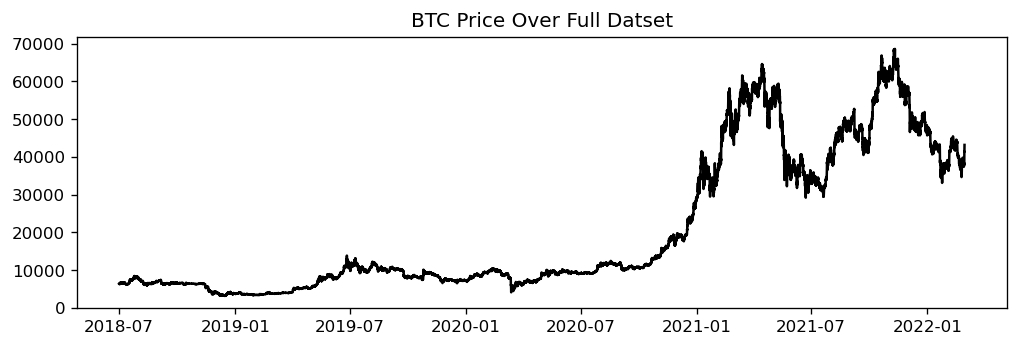

In [136]:
# Plotting our BTC Price

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Close'], color='black')
plt.title('BTC Price Over Full Datset')

Text(0.5, 1.0, 'BTC Price in last 1000 hours')

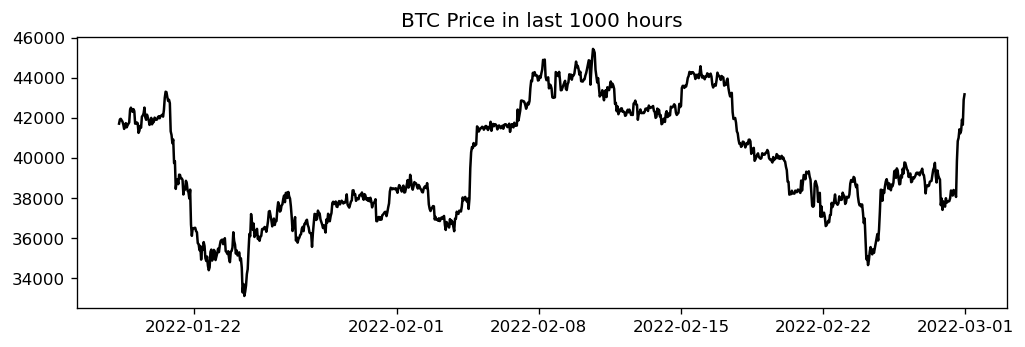

In [137]:
# Plotting our BTC Price

cutoff = 1000

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Close'][-cutoff:], color='black')
plt.title('BTC Price in last '+str(cutoff)+' hours')

# Differencing and Decomposition

## Differencing

*Differencing* simply means to take the difference between two values of our series:

$${y_t}^{'}=y_t-y_{t-1}$$

We can also introduce the *Lag Operator*:

$${L^n}y_t=y_{t-n}$$

Now, with this, we can write our differencing fo degree *d* as:

$$\Delta ^d y_t=(1-L)^d y_t=d_t$$

We want to do this so that our data is *Stationary*, or is such that its properties, such as mean and variance, do not change with time.

Now, we will plot the data differenced to see what it looks like.

Text(0.5, 1.0, 'BTC Price in last 1000 hours')

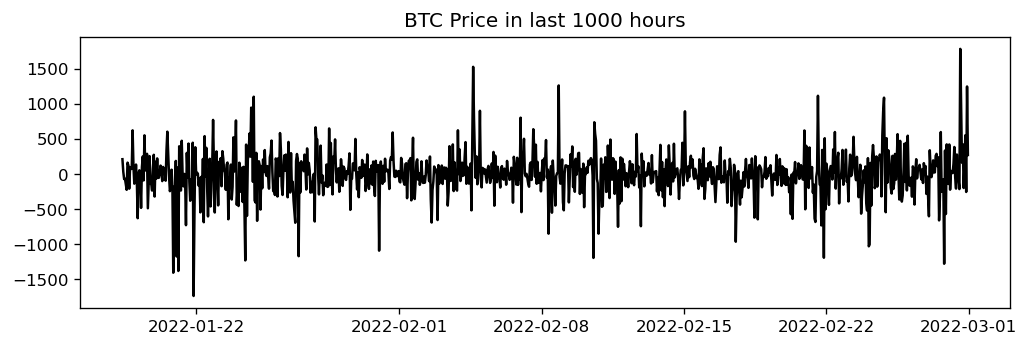

In [138]:
# Plotting our BTC Price with a single differencing

cutoff = 1000

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Close'][-cutoff:].diff(), color='black')
plt.title('BTC Price in last '+str(cutoff)+' hours')

Text(0.5, 1.0, 'BTC Price in last 1000 hours')

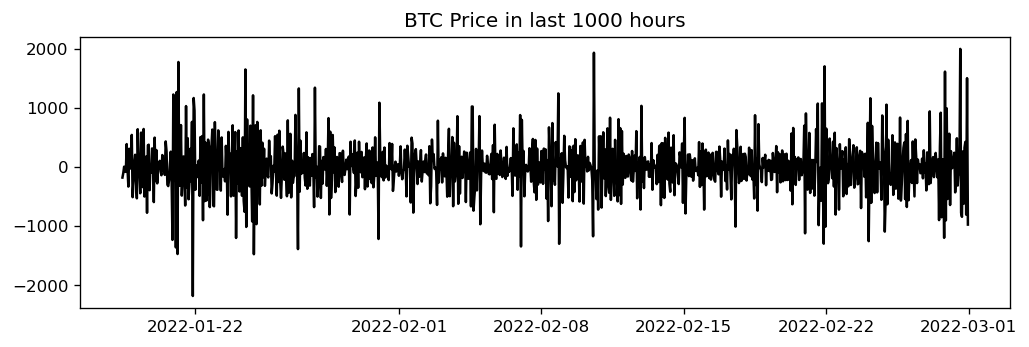

In [139]:
# Plotting our BTC Price with a second differencing

cutoff = 1000

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Close'][-cutoff:].diff().diff(), color='black')
plt.title('BTC Price in last '+str(cutoff)+' hours')

We will run an Augmented Dickey-Fuller Test now.

In [140]:
# No differencing

result = adfuller(X['Close'][-cutoff:])
print('ADF Statistic for BTC Close is '+str(result[0]))
print('p-value for BTC Closing Values is ' +str(result[1]))

ADF Statistic for BTC Close is -1.6540070410197452
p-value for BTC Closing Values is 0.45495148081020237


In [141]:
result = adfuller(X['Close'][-cutoff:].diff().dropna()) # Note, we must drop all na, as the 
# first has a value of nan after differencing
print('ADF Statistic for BTC Close Differenced Once is '+str(result[0]))
print('p-value for BTC Closing Values Differenced Once is ' +str(result[1]))

ADF Statistic for BTC Close Differenced Once is -21.243157841268676
p-value for BTC Closing Values Differenced Once is 0.0


So, we need to difference this time series one time so it is stationary.

In [142]:
# Our datasets

print('X datasets only taking into account the last 1000 hours','\n')
X_cut = X['Close'][-cutoff:]
print('Original cutoff dataframe:', '\n', X_cut)
print('\n')

X_cut_diff = X['Close'][-cutoff:].diff().dropna()
print('Differenced cutoff dataframe', '\n', X_cut_diff)
print('\n')

print('Training datasets', '\n')
X_cut_train = X_cut[:-100]
print('Original cutoff training dataframe:', '\n', X_cut_train)
print('\n')

X_cut_diff_train = X_cut_diff[:-100]
print('Differenced cutoff training dataframe', '\n', X_cut_diff_train)
print('\n')

print('Testing datasets', '\n')
X_cut_test = X_cut[-100:]
print('Original cutoff testing dataframe:', '\n', X_cut_test)
print('\n')

X_cut_diff_test = X_cut_diff[-100:]
print('Differenced cutoff testing dataframe', '\n', X_cut_diff_test)

X datasets only taking into account the last 1000 hours 

Original cutoff dataframe: 
 Date
2022-01-18 08:00:00    41715.54
2022-01-18 09:00:00    41926.89
2022-01-18 10:00:00    41958.28
2022-01-18 11:00:00    41886.78
2022-01-18 12:00:00    41819.68
                         ...   
2022-02-28 19:00:00    41362.52
2022-02-28 20:00:00    41914.97
2022-02-28 21:00:00    41659.53
2022-02-28 22:00:00    42907.32
2022-02-28 23:00:00    43178.98
Freq: H, Name: Close, Length: 1000, dtype: float64


Differenced cutoff dataframe 
 Date
2022-01-18 09:00:00     211.35
2022-01-18 10:00:00      31.39
2022-01-18 11:00:00     -71.50
2022-01-18 12:00:00     -67.10
2022-01-18 13:00:00    -141.62
                        ...   
2022-02-28 19:00:00     128.65
2022-02-28 20:00:00     552.45
2022-02-28 21:00:00    -255.44
2022-02-28 22:00:00    1247.79
2022-02-28 23:00:00     271.66
Freq: H, Name: Close, Length: 999, dtype: float64


Training datasets 

Original cutoff training dataframe: 
 Date
2022-01-18 

## Decomposition

### Undifferenced data

Now, we will decompose them to see what their components.

Additive Decomposition 



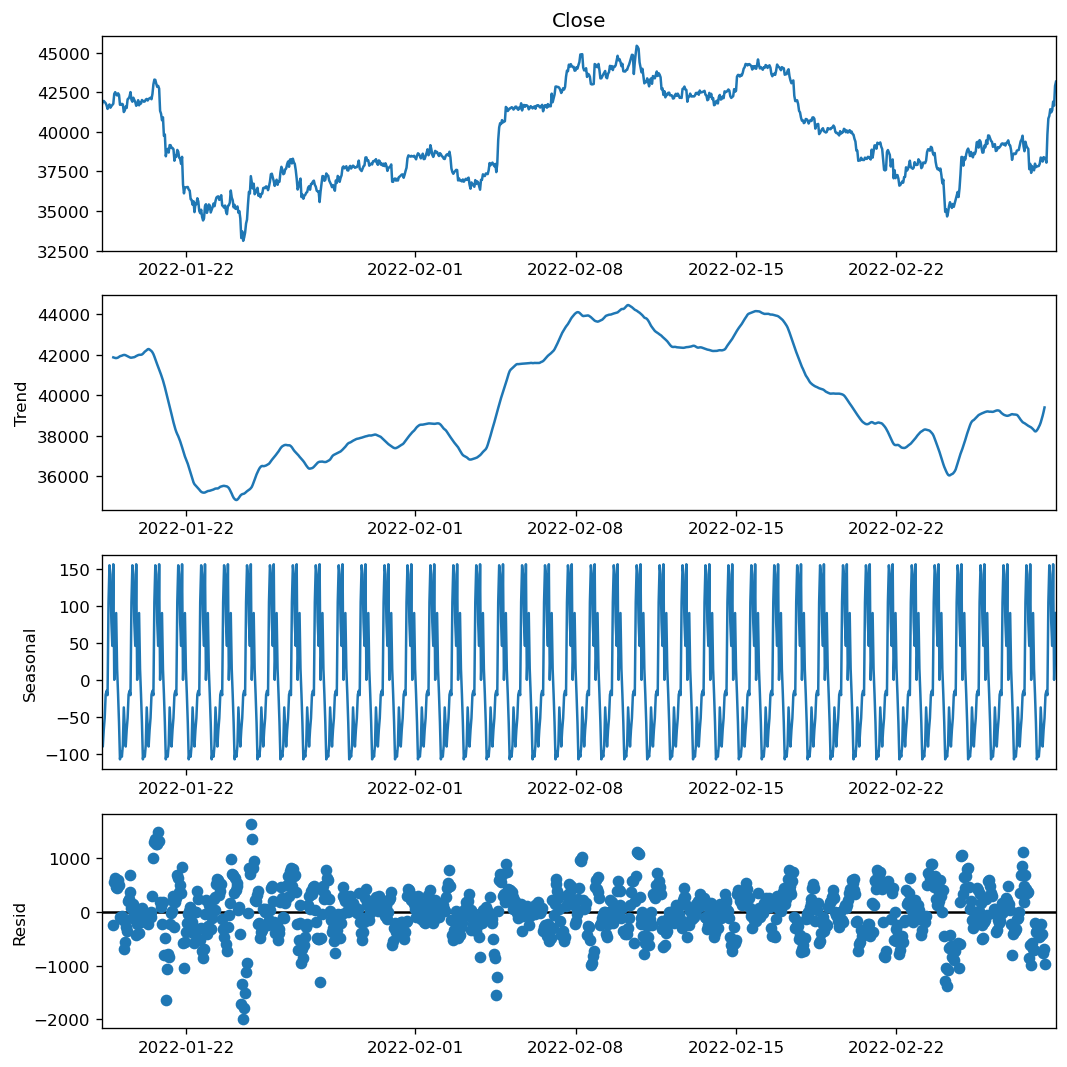

Multiplicative Decomposition 



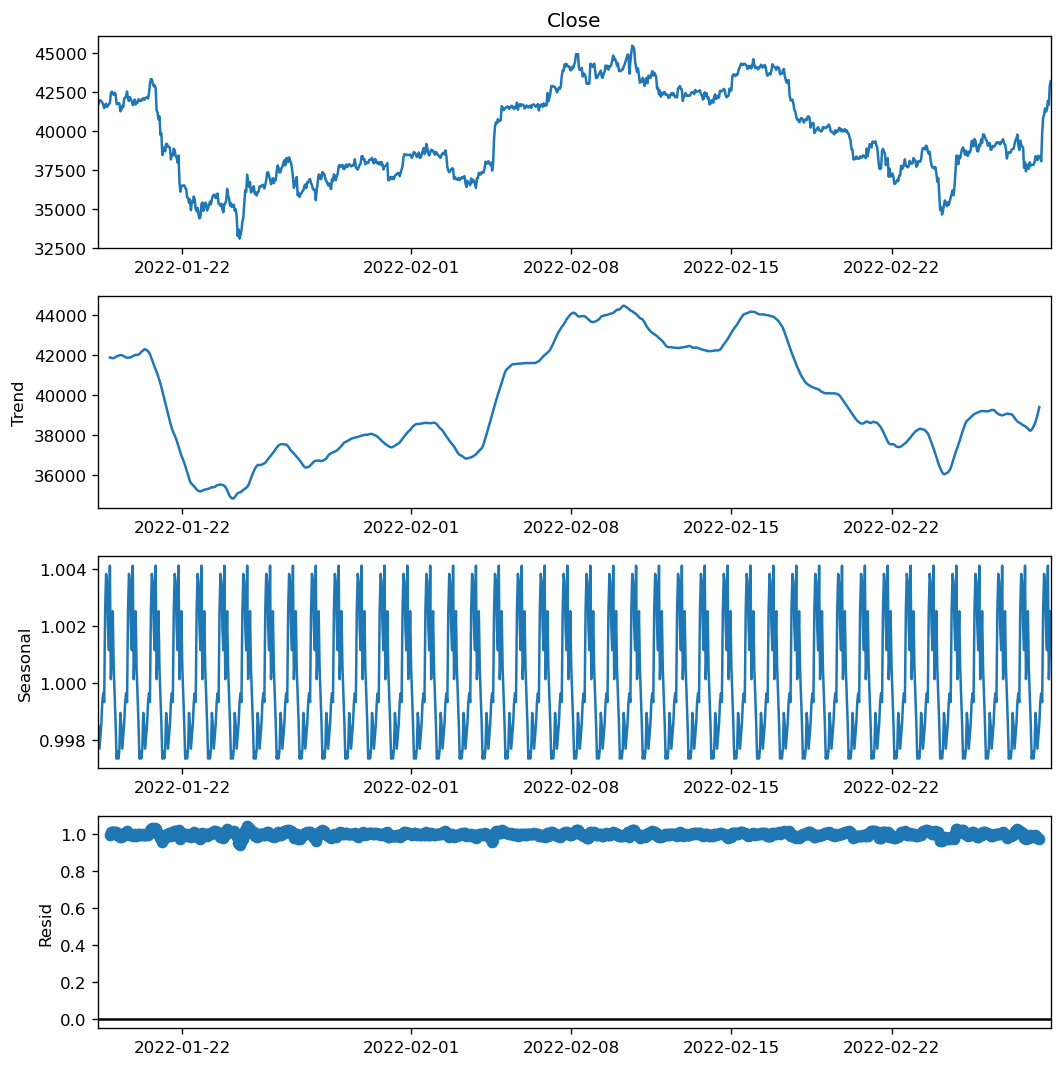

In [143]:
# Seasonal Decomposition

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Additive Decomposition
print('Additive Decomposition', '\n')
additive_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(X_cut,
                                                                     model='additive')

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

# Multiplicative Decomposition
print('Multiplicative Decomposition', '\n')
multiplicative_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(X_cut,
                                                                     model='multiplicative')

multiplicative_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

It seems as if there is a simple constant trend.

### Differenced data

Additive Decomposition 



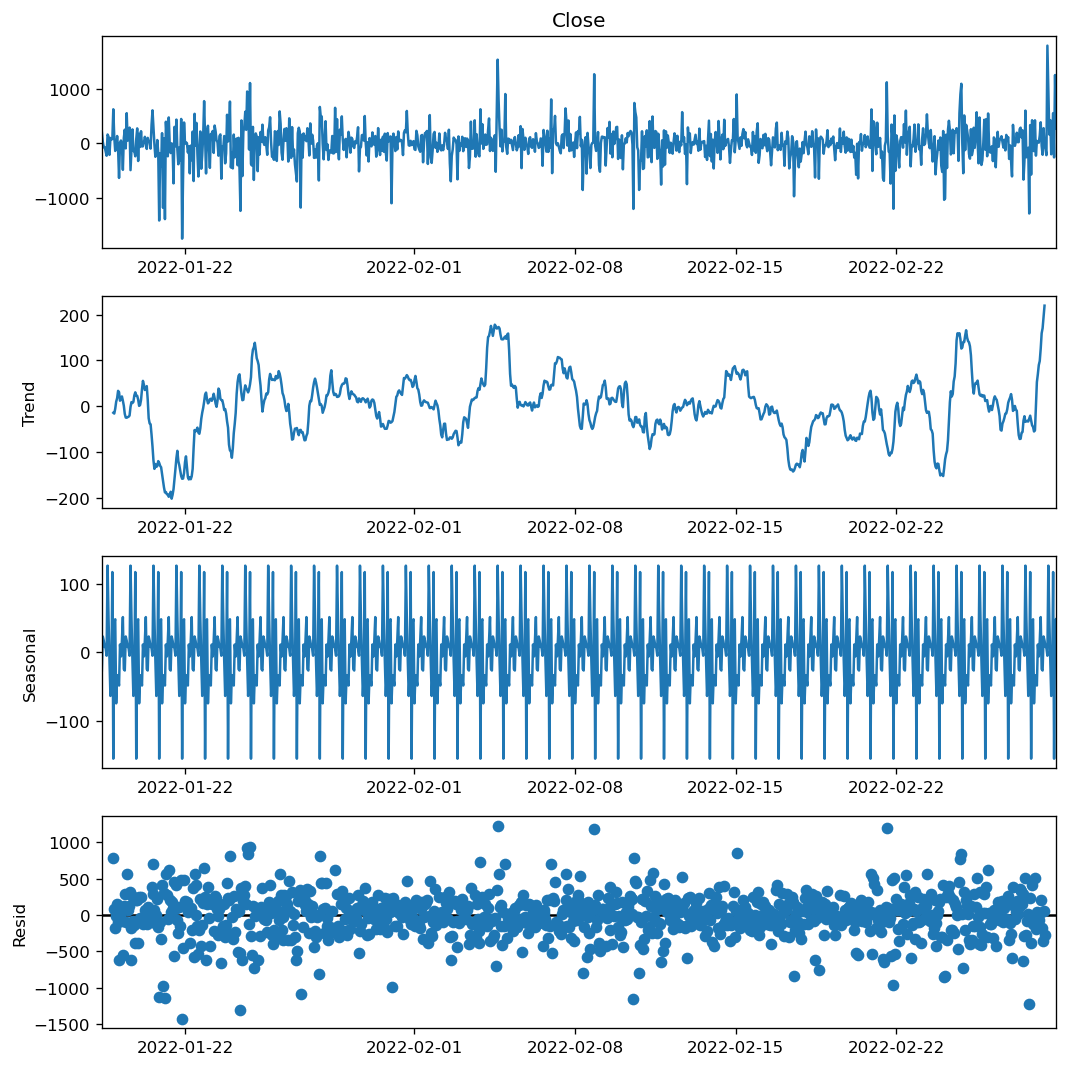

In [144]:
# Seasonal Decomposition

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Additive Decomposition
print('Additive Decomposition', '\n')
additive_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(X_cut_diff,
                                                                     model='additive')

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

We see no trend or just a constant trend around 0.

## Defining Root Mean Square

We are going to use the *Root Mean Square* for our performance metric. It can be written as:

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{N}(y_i -\hat{y}_i)^2}$$

In [145]:
def rmse(mse):
    return np.sqrt(mse)

# AutoRegressive Models

An *Autogregressive* model is one in which the current value of the series is calculated as a linear combination of *p* past observations.

This looks like:

$$y_t=\sum_{i=1}^{p} \phi _i y_{t-i} +c+ \epsilon_t$$

Using lag notation and droppping c, we can write this as a *Lag Polynomial*. This looks like:

$$\phi (L)^p y_t =\left(1-\sum_{i=1}^{p} \phi _i L^i \right)y_t=\epsilon_t$$

Though we know that our data needs to be differenced, we will fit a model doing so and not to see the difference. Before doing that, let's see the *Partial Autocorrelation*, defined as:

$$ PAC(y_i, y_{i-h})=\frac{Cov(y_i, y_{i-h}|y_{1-1}, ..., y_{i-h})}{\sqrt{Var(y_i | y_{i-1}, ..., y_{i-h+1})\times Var(y_{i-h} | y_{i-1}, ..., y_{i-h+1})}}$$

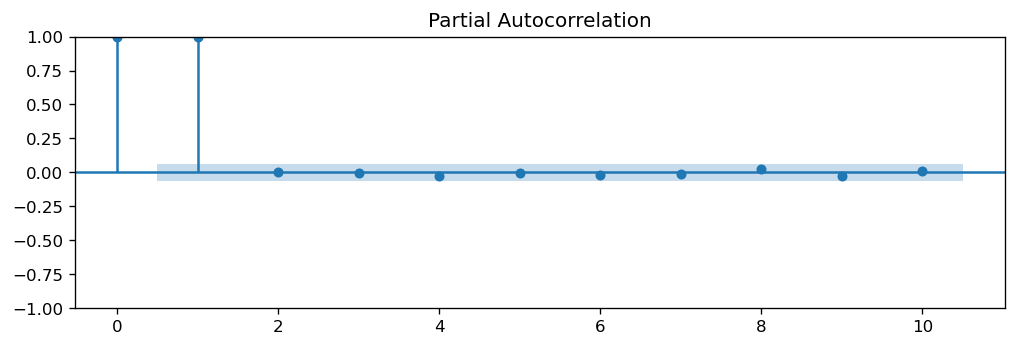

In [47]:
# Undifferenced PAC

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plot_pacf(X_cut, lags=10)
plt.show()

This seems to suggest an order of *p=1*

## Auto-ARIMA to find the best parameter p

For our Auto-ARIMA function, we must have a criterion from which it can choose the best model. We choose the *Akaike Information Criterion*. The formulation is:

$$AIC = 2k -ln(\hat{L})$$

In the above, $\hat{L}$ is the maximum value of the likelihood function for the model, roughly how well the model reproduces the data, and $k$ is the number of factors/regressors, or a measure of the complexity of the model.

In [48]:
# We will use the auto_arima function to find the best model

auto_model = auto_arima(X_cut_train, information_criterion='aic', start_q=0, max_q=0, seasonal=False, trend='c', suppress_warnings = True,  step_wise=False, trace=True,
                       stationary=True)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16920.549, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16920.549, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.839 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  900
Model:                        SARIMAX   Log Likelihood               -8458.275
Date:                Tue, 24 May 2022   AIC                          16920.549
Time:                        20:58:22   BIC                          16930.154
Sample:                             0   HQIC                         16924.218
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.979e+04     97.479    408.188      0.000    3.96e+04       4e+04
sigma2      8.523e+06   6.63e+05     12.853      0.000    7.22e+06    9.82e+06
===================================================================================
Ljung-Box (L1) (Q):                 891.86   Jarque-Bera (JB):                60.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         1.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We note that $ARIMA(0,0,0)$ with intercept is *white noise about the constant*.

## Fitting the best model found by Auto-ARIMA

In [49]:
start = time.time()
auto_model = SARIMAX(endog=X_cut_train, 
                order=(0, 0, 0), trend='c')
auto_model = auto_model.fit(disp=False)
auto_model.summary()
end = time.time()
print('This AR training took', end-start)

This AR training took 0.09830069541931152


In [50]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:                        SARIMAX   Log Likelihood               -8458.275
Date:                Tue, 24 May 2022   AIC                          16920.549
Time:                        20:58:23   BIC                          16930.154
Sample:                    01-18-2022   HQIC                         16924.218
                         - 02-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.979e+04     97.479    408.188      0.000    3.96e+04       4e+04
sigma2      8.523e+06   6.63e+05     12.853      0.000    7.22e+06    9.82e+06
===================================================================================
Ljung-Box (L1) (Q):                 891.86   Jarque-Bera (JB):                60.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         1.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

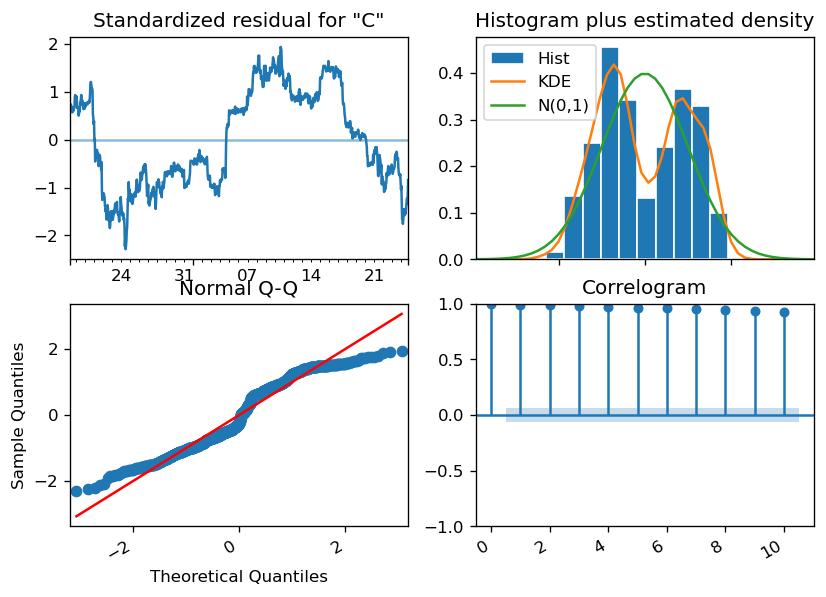

In [51]:
auto_model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

## Manually choosing the best parameter based on our plots

In [52]:
start = time.time()
man_model = SARIMAX(endog=X_cut_train, 
                order=(1, 0, 0), trend='c')
man_model = man_model.fit(disp=False)
end = time.time()
print('This AR training took', end-start)

This AR training took 0.18947625160217285


In [53]:
man_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -6434.308
Date:                Tue, 24 May 2022   AIC                          12874.617
Time:                        20:58:25   BIC                          12889.024
Sample:                    01-18-2022   HQIC                         12880.121
                         - 02-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    210.0341    130.898      1.605      0.109     -46.521     466.589
ar.L1          0.9947      0.003    297.811      0.000       0.988       1.001
sigma2      9.446e+04   2542.850     37.147      0.000    8.95e+04    9.94e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               762.34
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

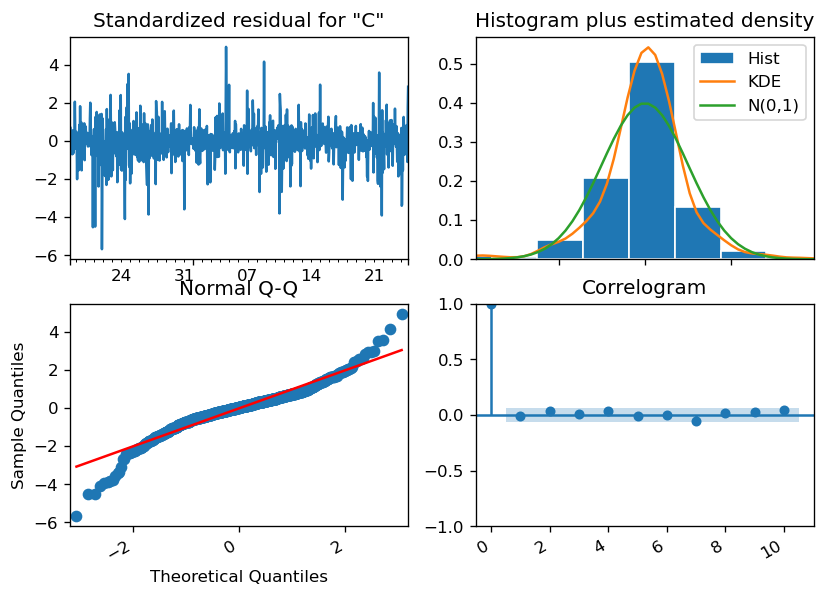

In [54]:
man_model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

## Out-of-Sample Forecasting

### Using forecasts at time t as input for t+1

In [55]:
auto_result = auto_model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1)
man_result = man_model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1)

print('The Root Mean Squared Error between the auto-results and the actual values is:', round(rmse(mean_squared_error(auto_result, X_cut_test)),3))
print('The Root Mean Squared Error between the manual-results and the actual values is:', round(rmse(mean_squared_error(man_result, X_cut_test)),3))

The Root Mean Squared Error between the auto-results and the actual values is: 1265.688
The Root Mean Squared Error between the manual-results and the actual values is: 1548.924


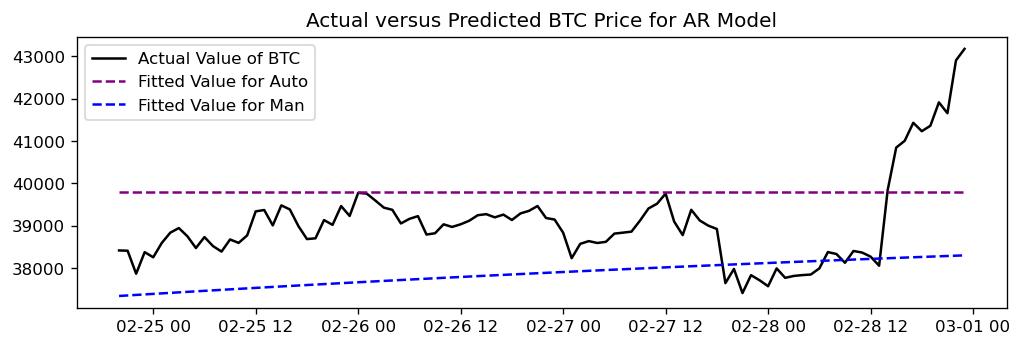

In [56]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X_cut_test, label='Actual Value of BTC', color='black')
plt.plot(auto_result, label='Fitted Value for Auto', color='purple', linestyle='--')
plt.plot(man_result, label='Fitted Value for Man', color='blue', linestyle='--')
plt.title('Actual versus Predicted BTC Price for AR Model')
plt.legend()

We see that with $AR(0)$, we just have the model predicting the trend line, or the intercept.
With $AR(1)$, we have a simple linear equation.

### Feeding the model known forecasts at time t for predictions at time t+1

In [57]:
def stepwise_forecast_with_known_values(train_vals, test_vals, p, d, q, trend):
    forecasts = []
    X = train_vals.copy()
    full_X = X.append(test_vals)
    for i in range(0,len(test_vals)):
        model = SARIMAX(endog=full_X[:-len(test_vals)+i], 
                order=(p, d, q), trend=trend)  
        model = model.fit(disp=False)
        forecast = model.forecast()
        forecasts.append(forecast[0])
        
    return forecasts
        

In [58]:
auto_forecasts = stepwise_forecast_with_known_values(X_cut_train, X_cut_test, 0, 0, 0, 'c')
man_forecasts = stepwise_forecast_with_known_values(X_cut_train, X_cut_test, 1, 0, 0, 'c')

print('The Root Mean Squared Error between the auto-results and the actual values is:', round(rmse(mean_squared_error(auto_forecasts, X_cut_test)),3))
print('The Root Mean Squared Error between the manual-results and the actual values is:', round(rmse(mean_squared_error(man_forecasts, X_cut_test)),3))

The Root Mean Squared Error between the auto-results and the actual values is: 1244.528
The Root Mean Squared Error between the manual-results and the actual values is: 395.989


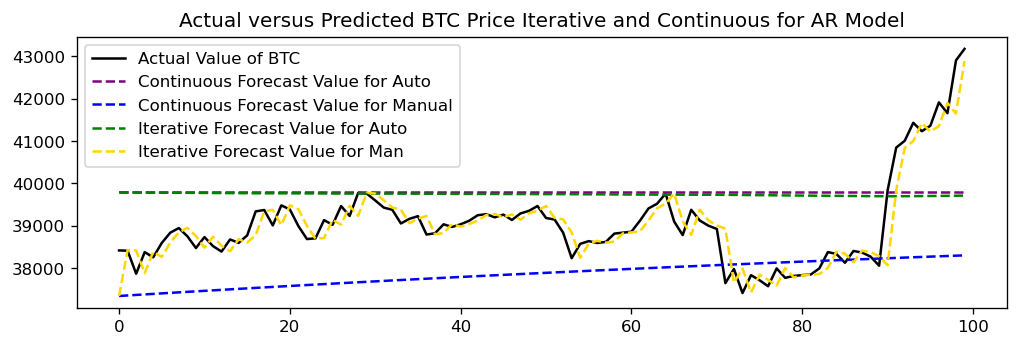

In [59]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot([val for val in X_cut_test], label='Actual Value of BTC', color='black')
plt.plot([val for val in auto_result], label='Continuous Forecast Value for Auto', color='purple', linestyle='--')
plt.plot([val for val in man_result], label='Continuous Forecast Value for Manual', color='blue', linestyle='--')
plt.plot(auto_forecasts, label='Iterative Forecast Value for Auto', color='green', linestyle='--')
plt.plot(man_forecasts, label='Iterative Forecast Value for Man', color='gold', linestyle='--')
plt.title('Actual versus Predicted BTC Price Iterative and Continuous for AR Model')
plt.legend()

It appears as if having at least an $AR(1)$ model and re-feeding it new values with it forecasts gives some ability to follow the line true value, though obviously lagged. However, what is happening with the $AR(0)$ model? We will plot it by itself to see.

Text(0.5, 1.0, 'Forecasts of the ARIMA(0,0,0)')

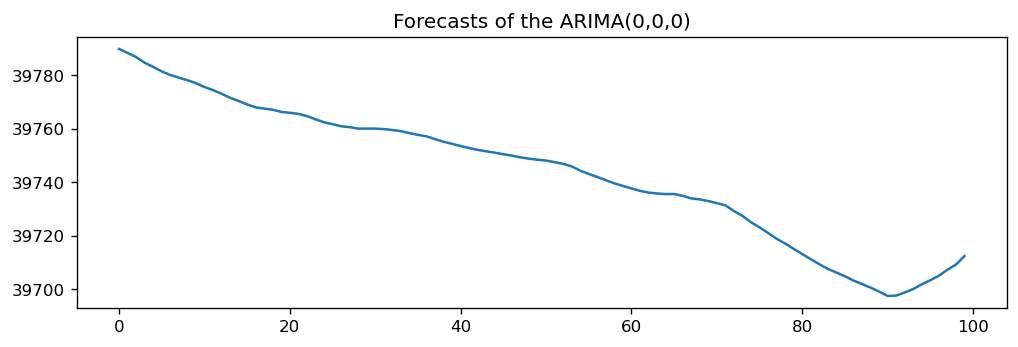

In [60]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(auto_forecasts)
plt.title('Forecasts of the ARIMA(0,0,0)')

So, we see that if we feed and retrain it stepwise, we just get a list of the trends it determined at that those timesteps.

# Moving Average Models

A *Moving Average* model is one in which the current value of the series is calculated as a linear combination of *q* past erros.

This looks like:

$$y_t=\sum_{i=1}^{q} \theta _i \epsilon_{t-i} + \epsilon_t$$

Using the lag polynomial notation and dropping c, we can write this as:

$$\theta (L)^q \epsilon_t =\left(1+\sum_{i=1}^{q} \theta _i L^i \right)\epsilon_t=y_t$$

We can use the *Autocorrelation* in the same was as we used the partial autocorrelation to find the value of the $q$ parameter. The autocorrelation at time $k$ is:

$$ r_k= \frac{\sum_{t=k+1}^{T}(y_t-\bar{y})(y_{t-k}-\bar{y})}{\sum_{t=1}^{T}(y_t-\bar{y})^2}$$

Or, simply:

$$Corr(y_t,y_{t-k})$$

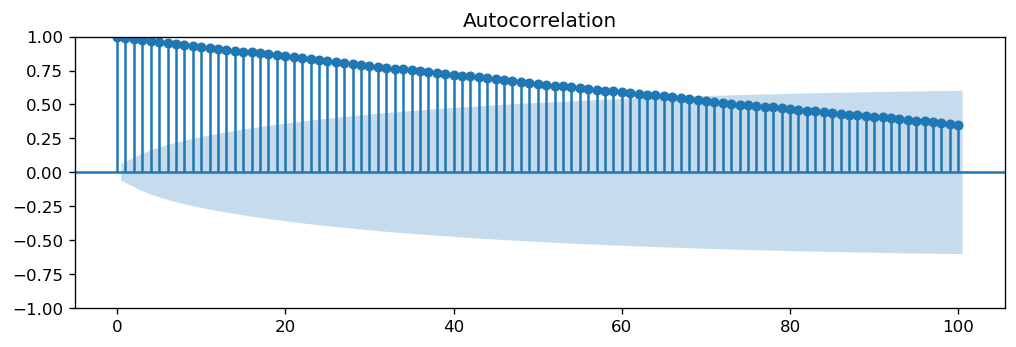

In [61]:
# Undifferenced AC

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plot_acf(X_cut, lags=100)
plt.show()

## Auto-ARIMA to find the best parameters

In [62]:
# We will use the auto_arima function to find the best model

auto_model = auto_arima(X_cut_train, information_criterion='aic', start_p=0, max_p=0, seasonal=False, trend='c', suppress_warnings = True,  step_wise=False, trace=True,
                       stationary=True)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=15012.786, Time=1.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16920.549, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15823.578, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16920.549, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=14509.160, Time=4.17 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=14113.271, Time=3.21 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=inf, Time=6.66 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=14113.271, Time=3.18 sec

Best model:  ARIMA(0,0,4)(0,0,0)[0]          
Total fit time: 19.701 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  900
Model:               SARIMAX(0, 0, 4)   Log Likelihood               -7050.635
Date:                Tue, 24 May 2022   AIC                          14113.271
Time:                        20:59:19   BIC                          14142.085
Sample:                             0   HQIC                         14124.278
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.976e+04    135.915    292.572      0.000    3.95e+04       4e+04
ma.L1          1.6889      0.028     60.819      0.000       1.634       1.743
ma.L2          1.8507      0.045     40.732      0.000       1.762       1.940
ma.L3          1.3529      0.046     29.562      0.000       1.263       1.443
ma.L4          0.5659      0.029     19.544      0.000       0.509       0.623
sigma2      3.716e+05   1.72e+04     21.650      0.000    3.38e+05    4.05e+05
===================================================================================
Ljung-Box (L1) (Q):                  77.17   Jarque-Bera (JB):                 6.44
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               0.69   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fitting the best model found by Auto-ARIMA

In [63]:
start=time.time()
auto_model = SARIMAX(endog=X_cut_train, 
                order=(0, 0, 4), trend='c')
auto_model = auto_model.fit(disp=False)
auto_model.summary()
end=time.time()
print('This MA training took', end-start)

This MA training took 3.5837974548339844


In [64]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:               SARIMAX(0, 0, 4)   Log Likelihood               -7050.635
Date:                Tue, 24 May 2022   AIC                          14113.271
Time:                        20:59:22   BIC                          14142.085
Sample:                    01-18-2022   HQIC                         14124.278
                         - 02-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.976e+04    135.915    292.572      0.000    3.95e+04       4e+04
ma.L1          1.6889      0.028     60.819      0.000       1.634       1.743
ma.L2          1.8507      0.045     40.732      0.000       1.762       1.940
ma.L3          1.3529      0.046     29.562      0.000       1.263       1.443
ma.L4          0.5659      0.029     19.544      0.000       0.509       0.623
sigma2      3.716e+05   1.72e+04     21.650      0.000    3.38e+05    4.05e+05
===================================================================================
Ljung-Box (L1) (Q):                  77.17   Jarque-Bera (JB):                 6.44
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               0.69   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Manually choosing the best parameters

In [65]:
# # Loop search for the best parameter q
# rmses = []
# loop = range(0,60)
# for i in loop:
#     man_model = SARIMAX(endog=X_cut_train, 
#                 order=(0, 0, i), trend='c')
#     man_model = man_model.fit(disp=False)
#     man_result = man_model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1)
#     rmse = rmse(mean_squared_error(man_result, X_cut_test))
#     print('For q=', i, 'Mean Squared Error=', mse)
#     rmses.append(rmse)
# print('The best model parameter, based on Mean Squared Error, is:', loop[rmses.index(min(rmses))])

In [66]:
# print('The RMSE of this q is:',rmses[rmses.index(min(rmses))])

Our loop found $q=29$ as the best value.

In [67]:
start = time.time()
man_model = SARIMAX(endog=X_cut_train, 
                order=(0, 0, 29), trend='c')
man_model = man_model.fit(disp=False)
end = time.time()
print('This MA training took', end-start)

This MA training took 29.75660514831543


In [68]:
man_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:              SARIMAX(0, 0, 29)   Log Likelihood               -7891.547
Date:                Tue, 24 May 2022   AIC                          15845.093
Time:                        20:59:52   BIC                          15993.968
Sample:                    01-18-2022   HQIC                         15901.965
                         - 02-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.957e+04   6382.808      6.200      0.000    2.71e+04    5.21e+04
ma.L1          0.3828      0.680      0.563      0.574      -0.951       1.716
ma.L2          0.6318      0.674      0.937      0.349      -0.689       1.953
ma.L3          0.7460      0.728      1.024      0.306      -0.682       2.174
ma.L4          0.6901      0.875      0.789      0.430      -1.024       2.404
ma.L5          0.6868      0.916      0.750      0.453      -1.108       2.481
ma.L6          0.6689      0.865      0.773      0.440      -1.027       2.365
ma.L7          0.4287      0.890      0.482      0.630      -1.315       2.172
ma.L8          0.6662      0.938      0.710      0.478      -1.173       2.505
ma.L9          0.8618      0.926      0.931      0.352      -0.952       2.676
ma.L10         0.4268      1.008      0.423      0.672      -1.549       2.403
ma.L11         0.9876      1.147      0.861      0.389      -1.261       3.236
ma.L12         0.6124      1.134      0.540      0.589      -1.610       2.835
ma.L13         0.9319      1.197      0.778      0.436      -1.415       3.279
ma.L14         0.5427      1.230      0.441      0.659      -1.869       2.954
ma.L15         0.9654      1.119      0.863      0.388      -1.228       3.158
ma.L16         0.6256      1.193      0.525      0.600      -1.712       2.963
ma.L17         0.6561      1.195      0.549      0.583      -1.687       2.999
ma.L18         0.7602      1.183      0.642      0.521      -1.559       3.080
ma.L19         0.4255      1.000      0.426      0.670      -1.534       2.385
ma.L20         0.6151      1.030      0.597      0.550      -1.404       2.634
ma.L21         0.5208      0.955      0.545      0.586      -1.352       2.393
ma.L22         0.5227      0.965      0.542      0.588      -1.368       2.414
ma.L23         0.3802      0.932      0.408      0.683      -1.446       2.206
ma.L24         0.5184      0.870      0.596      0.551      -1.186       2.223
ma.L25         0.1771      0.916      0.193      0.847      -1.618       1.972
ma.L26         0.4384      0.871      0.503      0.615      -1.270       2.146
ma.L27         0.0301      0.776      0.039      0.969      -1.490       1.551
ma.L28         0.0569      0.703      0.081      0.935      -1.320       1.434
ma.L29        -0.0162      0.828     -0.020      0.984      -1.638       1.606
sigma2      6.086e+06      0.288   2.11e+07      0.000    6.09e+06    6.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                15.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.16
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

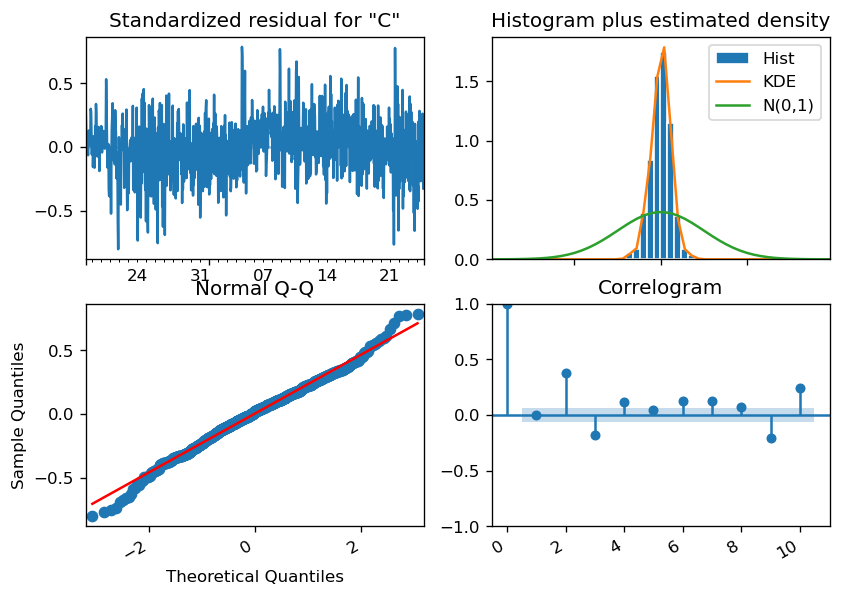

In [69]:
man_model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

## Out-of-Sample Forecasting

### Using forecasts at time t as input for t+1

In [70]:
auto_result = auto_model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1)
man_result = man_model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1)

print('The Root Mean Squared Error between the auto-results and the actual values is:', round(rmse(mean_squared_error(auto_result, X_cut_test)),3))
print('The Root Mean Squared Error between the manual-results and the actual values is:', round(rmse(mean_squared_error(man_result, X_cut_test)),3))

The Root Mean Squared Error between the auto-results and the actual values is: 1238.761
The Root Mean Squared Error between the manual-results and the actual values is: 1181.004


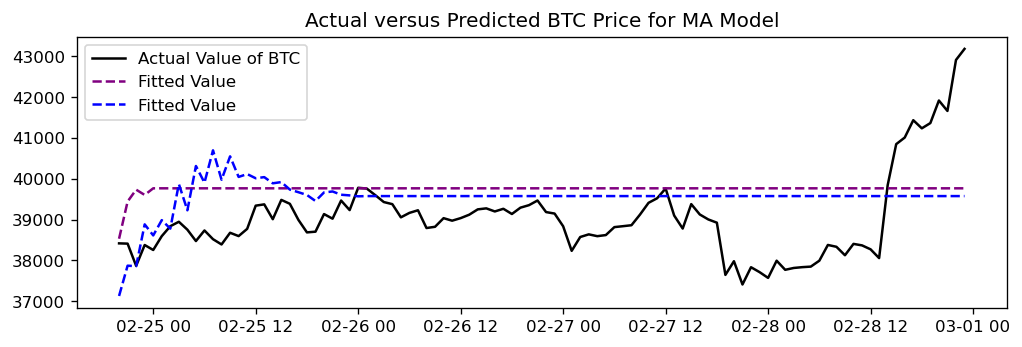

In [71]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X_cut_test, label='Actual Value of BTC', color='black')
plt.plot(auto_result, label='Fitted Value', color='purple', linestyle='--')
plt.plot(man_result, label='Fitted Value', color='blue', linestyle='--')
plt.title('Actual versus Predicted BTC Price for MA Model')
plt.legend()

### Feeding the model known forecasts at time t for predictions at time t+1

In [72]:
auto_forecasts = stepwise_forecast_with_known_values(X_cut_train, X_cut_test, 0, 0, 4, 'c')
man_forecasts = stepwise_forecast_with_known_values(X_cut_train, X_cut_test, 0, 0, 0, 'c')

print('The Root Mean Squared Error between the auto-results and the actual values is:', round(rmse(mean_squared_error(auto_forecasts, X_cut_test)),3))
print('The Root Mean Squared Error between the manual-results and the actual values is:', round(rmse(mean_squared_error(man_forecasts, X_cut_test)),3))

The Root Mean Squared Error between the auto-results and the actual values is: 560.472
The Root Mean Squared Error between the manual-results and the actual values is: 1244.528


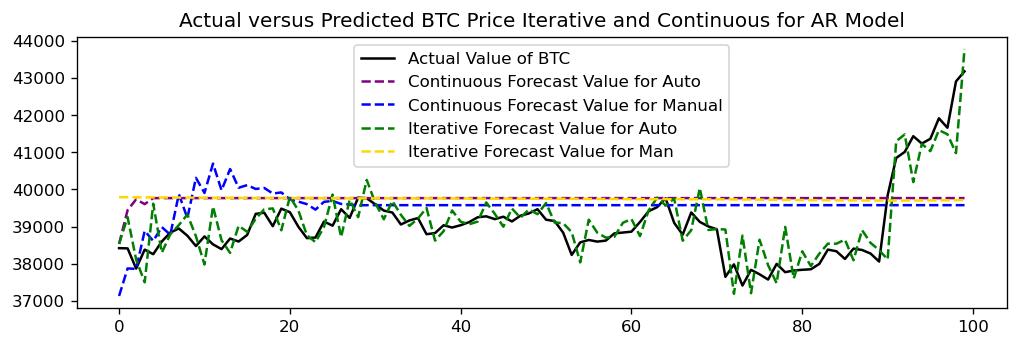

In [73]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot([val for val in X_cut_test], label='Actual Value of BTC', color='black')
plt.plot([val for val in auto_result], label='Continuous Forecast Value for Auto', color='purple', linestyle='--')
plt.plot([val for val in man_result], label='Continuous Forecast Value for Manual', color='blue', linestyle='--')
plt.plot(auto_forecasts, label='Iterative Forecast Value for Auto', color='green', linestyle='--')
plt.plot(man_forecasts, label='Iterative Forecast Value for Man', color='gold', linestyle='--')
plt.title('Actual versus Predicted BTC Price Iterative and Continuous for AR Model')
plt.legend()

# AutoRegressive Moving Average

This model is one with a differenced time series, an AR model, and a MA component. It is commonly written as:

$$ ARMA(p, q)$$

The mathematical formulation can be written as:

$$ y_t=\sum_{i=1}^{p}\phi_i y_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + c +\epsilon_t $$

Though, using lag polynomials, it is:

$$\phi (L)^p y_t=\theta(L)^q \epsilon_t $$

From now on, we are just going to use Auto-ARIMA.

## Auto-ARIMA to find the best parameters

In [74]:
# We will use the auto_arima function to find the best model

model = auto_arima(X_cut_train, information_criterion='aic', seasonal=False, trend='c', suppress_warnings = True,  step_wise=False, trace=True,
                       stationary=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=12879.169, Time=1.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16920.549, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15823.578, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16920.549, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=12877.382, Time=0.57 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=15012.786, Time=1.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12876.587, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12877.169, Time=1.59 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12876.587, Time=0.37 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 7.408 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  900
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -6434.294
Date:                Tue, 24 May 2022   AIC                          12876.587
Time:                        21:06:05   BIC                          12895.797
Sample:                             0   HQIC                         12883.926
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    211.2050    130.807      1.615      0.106     -45.172     467.583
ar.L1          0.9947      0.003    297.961      0.000       0.988       1.001
ma.L1         -0.0056      0.027     -0.207      0.836      -0.058       0.047
sigma2      9.471e+04   2567.191     36.892      0.000    8.97e+04    9.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               764.12
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fitting the best model found by Auto-ARIMA

In [75]:
start = time.time()
model = SARIMAX(endog=X_cut_train, 
                order=(1, 0, 1), trend='c')
model = model.fit(disp=False)
end = time.time()
print('This ARMA training took', end-start)

This ARMA training took 0.36862802505493164


In [76]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -6434.294
Date:                Tue, 24 May 2022   AIC                          12876.587
Time:                        21:06:05   BIC                          12895.797
Sample:                    01-18-2022   HQIC                         12883.926
                         - 02-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    211.2050    130.807      1.615      0.106     -45.172     467.583
ar.L1          0.9947      0.003    297.961      0.000       0.988       1.001
ma.L1         -0.0056      0.027     -0.207      0.836      -0.058       0.047
sigma2      9.471e+04   2567.191     36.892      0.000    8.97e+04    9.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               764.12
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see that this model is *almost* the same as the $AR(1)$ model, with a *very* small $q$ component.

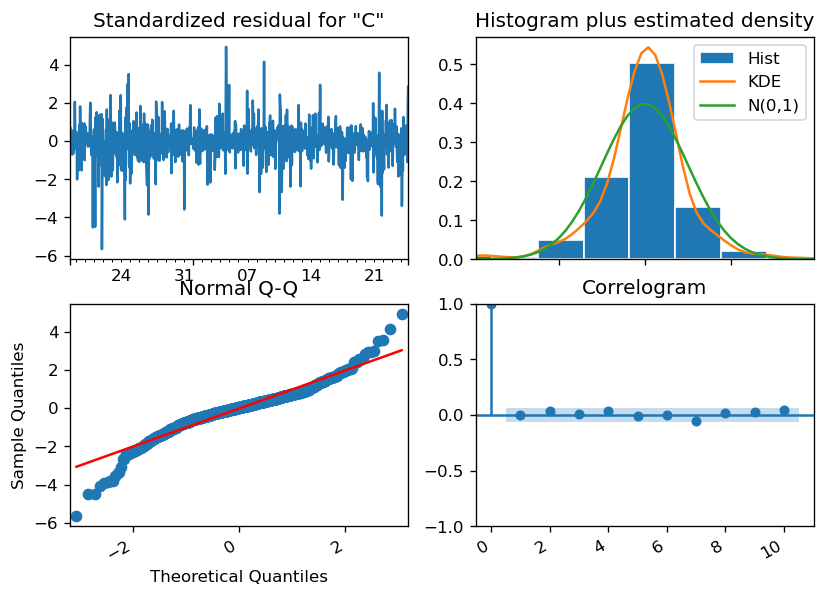

In [77]:
model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

## Out-of-Sample Forecasting

### Using forecasts at time t as input for t+1

In [78]:
result = model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1)

print('The Root Mean Squared Error between the results and the actual values is:', round(rmse(mean_squared_error(result, X_cut_test)),3))

The Root Mean Squared Error between the results and the actual values is: 1549.626


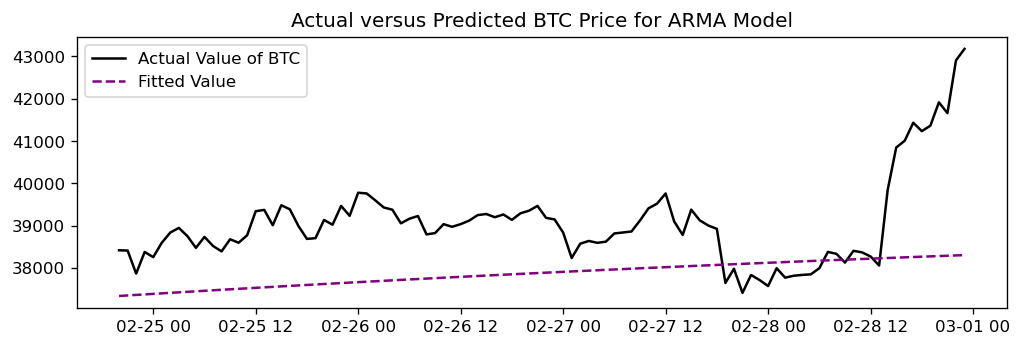

In [79]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X_cut_test, label='Actual Value of BTC', color='black')
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price for ARMA Model')
plt.legend()

Let's see this fitted value a bit closer.

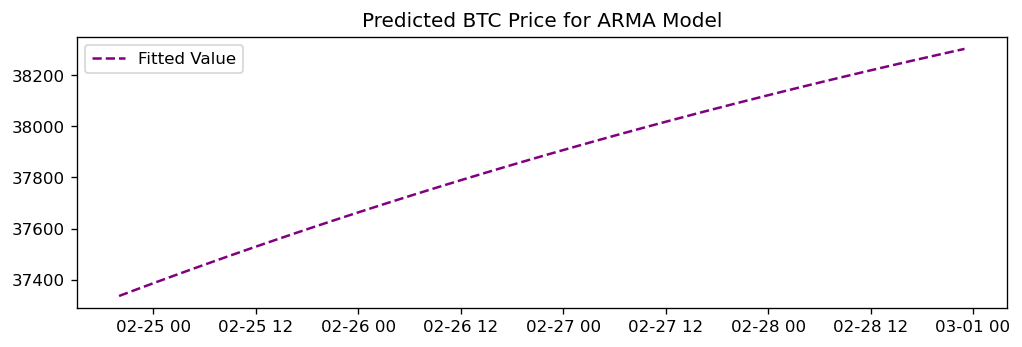

In [80]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Predicted BTC Price for ARMA Model')
plt.legend()

Even though it *seemed* as if it was a straight line, we see that it is not.

### Feeding the model known forecasts at time t for predictions at time t+1

In [81]:
forecasts = stepwise_forecast_with_known_values(X_cut_train, X_cut_test, 1, 0, 1, 'c')

print('The Root Mean Squared Error between the forecasts and the actual values is:', round(rmse(mean_squared_error(forecasts, X_cut_test)),3))

The Root Mean Squared Error between the forecasts and the actual values is: 396.68


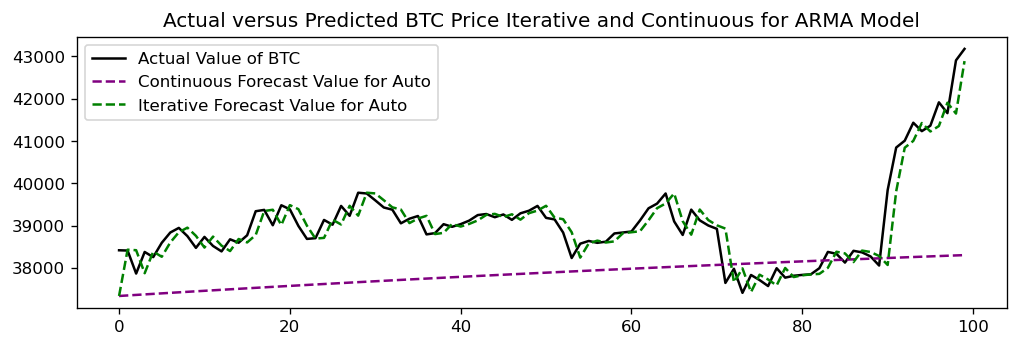

In [82]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot([val for val in X_cut_test], label='Actual Value of BTC', color='black')
plt.plot([val for val in result], label='Continuous Forecast Value for Auto', color='purple', linestyle='--')
plt.plot(forecasts, label='Iterative Forecast Value for Auto', color='green', linestyle='--')
plt.title('Actual versus Predicted BTC Price Iterative and Continuous for ARMA Model')
plt.legend()

# Autoregressive Integrated Moving Average

This model is one with a differenced time series, an AR model, and a MA component. It is commonly written as:

$$ ARIMA(p, d, q)$$

The mathematical formulation can be written as:

$$ d_t=\sum_{i=1}^{p}\phi_i d_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + c +\epsilon_t $$

Though, using lag polynomials, it is:

$$\phi (L)^p \Delta^d y_t=\theta(L)^q \epsilon_t $$

## Auto-ARIMA to find the best parameters

In [83]:
# We will use the auto_arima function to find the best model

# Let's try it with the undifferenced and allow the model to difference it if it chooses to

model = auto_arima(X_cut_train, information_criterion='aic', seasonal=False, trend='c', suppress_warnings = True,  step_wise=False, trace=True,
                       stationary=False)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12861.792, Time=1.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12856.497, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12858.498, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12858.504, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12856.497, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12858.477, Time=2.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.958 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  900
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6426.249
Date:                Tue, 24 May 2022   AIC                          12856.497
Time:                        21:06:51   BIC                          12866.100
Sample:                             0   HQIC                         12860.166
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.8798     10.465     -0.466      0.641     -25.391      15.631
sigma2      9.471e+04   2554.201     37.080      0.000    8.97e+04    9.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               748.12
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see that all it did is difference the time series. Let's give it the differenced series and see what happens.

In [84]:
# Now, let's give it the differenced time series and let it difference if it wants

model = auto_arima(X_cut_diff_train, information_criterion='aic', seasonal=False, trend='c', suppress_warnings = True,  step_wise=False, trace=True,
                       stationary=False)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12861.520, Time=1.81 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12856.497, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12858.432, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12858.443, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12858.101, Time=1.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12856.497, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 3.710 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  899
Model:                        SARIMAX   Log Likelihood               -6426.249
Date:                Tue, 24 May 2022   AIC                          12856.497
Time:                        21:06:55   BIC                          12866.100
Sample:                             0   HQIC                         12860.166
                                - 899                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.8798     10.465     -0.466      0.641     -25.391      15.631
sigma2      9.471e+04   2554.201     37.080      0.000    8.97e+04    9.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               748.12
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see that even though it *could* have differenced it, it did not. This is consistent without our Augmented Dickey Test above.

Further, we found that with the differenced time series, it fit *the same model* as the undifferenced after giving it a *d* component of 1.

## Fitting the best model found by Auto-ARIMA

In [85]:
start = time.time()
model = SARIMAX(endog=X_cut_train, 
                order=(0, 1, 0), trend='c')
model = model.fit(disp=False)
end = time.time()
print('This ARIMA training took', end-start)

This ARIMA training took 0.10487127304077148


In [86]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6426.249
Date:                Tue, 24 May 2022   AIC                          12856.497
Time:                        21:06:55   BIC                          12866.100
Sample:                    01-18-2022   HQIC                         12860.166
                         - 02-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.8798     10.465     -0.466      0.641     -25.391      15.631
sigma2      9.471e+04   2554.201     37.080      0.000    8.97e+04    9.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               748.12
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

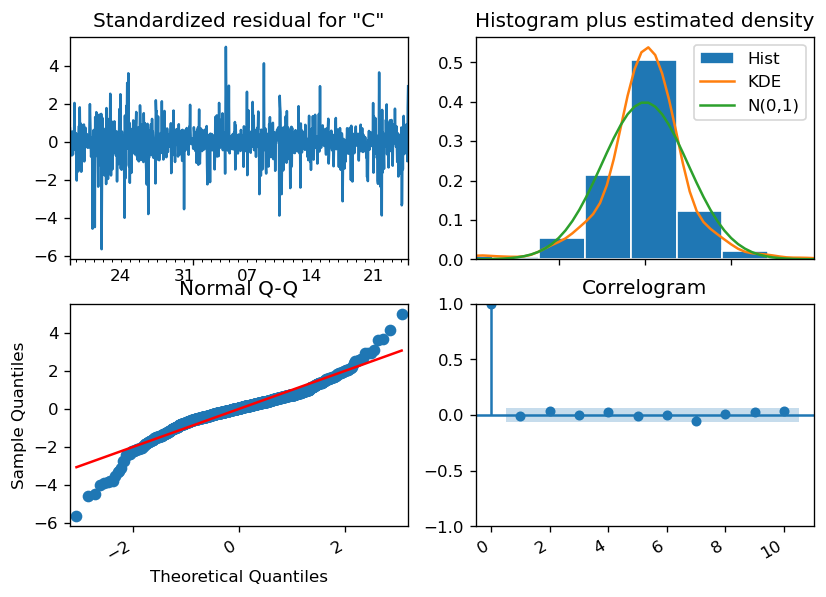

In [87]:
model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

## Out-of-Sample Forecasting

### Using forecasts at time t as input for t+1

In [88]:
result = model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1)

print('The Root Mean Squared Error between the results and the actual values is:', round(rmse(mean_squared_error(result, X_cut_test)),3))

The Root Mean Squared Error between the results and the actual values is: 2241.737


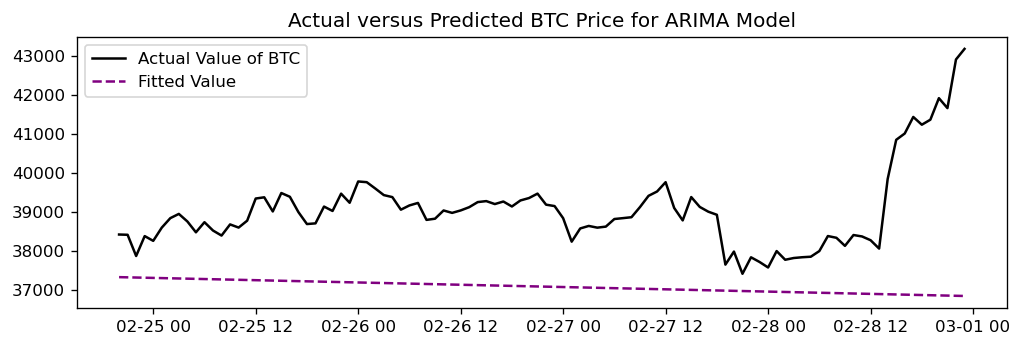

In [89]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X_cut_test, label='Actual Value of BTC', color='black')
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price for ARIMA Model')
plt.legend()

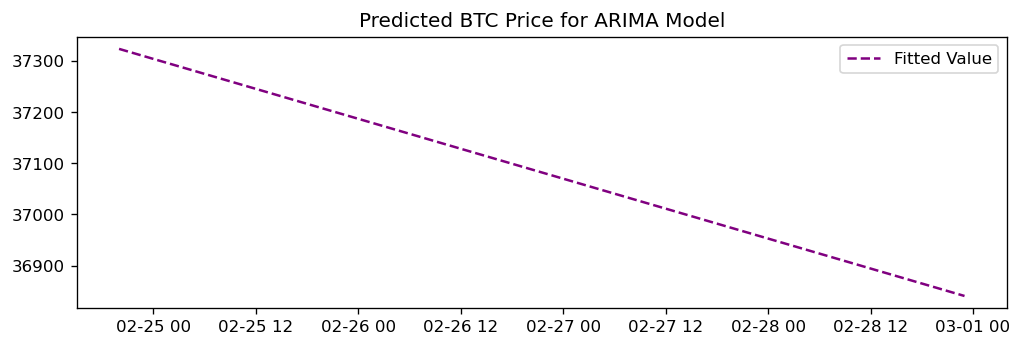

In [90]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Predicted BTC Price for ARIMA Model')
plt.legend()

### Feeding the model known forecasts at time t for predictions at time t+1

In [91]:
forecasts = stepwise_forecast_with_known_values(X_cut_train, X_cut_test, 0, 1, 0, 'c')

print('The Root Mean Squared Error between the forecasts and the actual values is:', round(rmse(mean_squared_error(forecasts, X_cut_test)),3))

The Root Mean Squared Error between the forecasts and the actual values is: 397.102


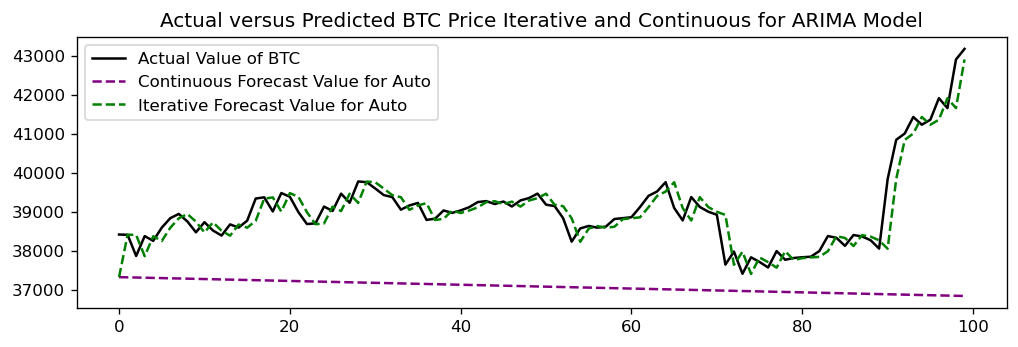

In [92]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot([val for val in X_cut_test], label='Actual Value of BTC', color='black')
plt.plot([val for val in result], label='Continuous Forecast Value for Auto', color='purple', linestyle='--')
plt.plot(forecasts, label='Iterative Forecast Value for Auto', color='green', linestyle='--')
plt.title('Actual versus Predicted BTC Price Iterative and Continuous for ARIMA Model')
plt.legend()

# AutoRegressive Integrated Moving Average with eXogenous variables

We can now augments our original $ARIMA$ model with *eXogenous variables*, or outside factors that might influence the time series. Doing so, we get $ARIMAX$:

$$ d_t=\sum_{i=1}^{p}\phi_i d_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \sum_{i=1}^{r}\beta_i {x_t}^i + c +\epsilon_t $$

Though, using lag polynomials, it is:

$$\phi (L)^p \Delta^d y_t=\theta(L)^q \epsilon_t + \sum_{i=1}^{r}\beta_i {x_t}^i$$

## Setting up our dataframe with eXogenous variables

We need to create a new variable to play with. Let's use *Relative Strength Index*, or RSI

In [93]:
def rsi(df_history, steps, append):
    """
    append is boolean True or False
    If append == True, will append the TA to the df
    If append == False, will return the information as a series, so it should be definied
    """
    if append == True:
        df_history.ta.rsi(length=steps, append=True)
    elif append == False:
        rsi = ta.rsi(df_history["Close"], length=steps)
        return rsi

In [94]:
rsi(X, 10, True)

In [95]:
# Getting our exog in the right shape

def exog_reshape(exog):
    exog = np.array(exog)
    exog = exog.reshape(-1,1)
    print(exog.shape)
    
    return exog

In [96]:
exog_full = exog_reshape(X['RSI_10'][-cutoff:])
exog_train = exog_reshape(X['RSI_10'][-cutoff:-100])
exog_test = exog_reshape(X['RSI_10'][-100:])

(1000, 1)
(900, 1)
(100, 1)


## Auto-ARIMA to find the best parameters

In [97]:
auto_model = auto_arima(X_cut_train, exog_train, information_criterion='aic', seasonal=False,
                        trend='c', suppress_warnings = True,  step_wise=False, trace=True,
                        stationary=False)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11346.019, Time=3.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11418.771, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11403.773, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11409.032, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11418.771, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11344.670, Time=1.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11374.406, Time=1.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11352.153, Time=1.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11345.571, Time=3.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11361.804, Time=1.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11344.068, Time=2.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11359.035, Time=0.79 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11345.979, Time=2.74 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11348.449, Time=1.06 sec
 ARIMA(3,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  900
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -5666.034
Date:                Tue, 24 May 2022   AIC                          11344.068
Time:                        21:07:38   BIC                          11372.876
Sample:                             0   HQIC                         11355.074
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7477      2.159     -0.809      0.418      -5.980       2.484
x1            41.6271      0.436     95.389      0.000      40.772      42.482
ar.L1          0.6060      0.074      8.228      0.000       0.462       0.750
ar.L2          0.1523      0.023      6.697      0.000       0.108       0.197
ma.L1         -0.5401      0.075     -7.159      0.000      -0.688      -0.392
sigma2      1.743e+04    409.906     42.531      0.000    1.66e+04    1.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              6839.15
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fitting the best model found by Auto-ARIMA

In [98]:
start = time.time()
model = SARIMAX(endog=X_cut_train, exog=exog_train, order=(2, 1, 1), trend='c')
model = model.fit(disp=False)
end = time.time()
print('This ARIMAX training took', end-start)

This ARIMAX training took 2.5063555240631104


In [99]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -5666.034
Date:                Tue, 24 May 2022   AIC                          11344.068
Time:                        21:07:40   BIC                          11372.876
Sample:                    01-18-2022   HQIC                         11355.074
                         - 02-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7477      2.159     -0.809      0.418      -5.980       2.484
x1            41.6271      0.436     95.389      0.000      40.772      42.482
ar.L1          0.6060      0.074      8.228      0.000       0.462       0.750
ar.L2          0.1523      0.023      6.697      0.000       0.108       0.197
ma.L1         -0.5401      0.075     -7.159      0.000      -0.688      -0.392
sigma2      1.743e+04    409.906     42.531      0.000    1.66e+04    1.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              6839.15
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

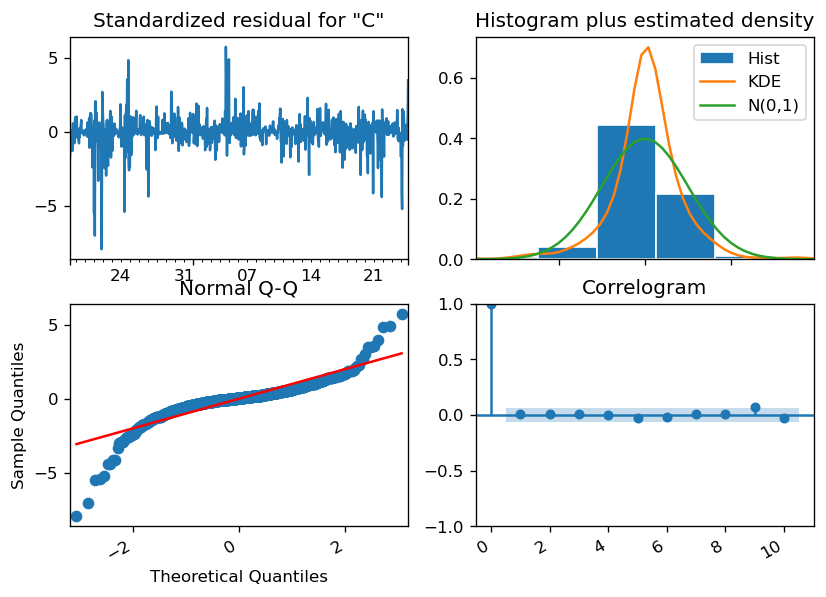

In [100]:
model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

## Out-of-Sample Forecasting

### Using forecasts at time t as input for t+1

In [101]:
result = model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1, exog=exog_test)

print('The Root Mean Squared Error between the results and the actual values is:', round(rmse(mean_squared_error(result, X_cut_test)),3))

The Root Mean Squared Error between the results and the actual values is: 2197.814


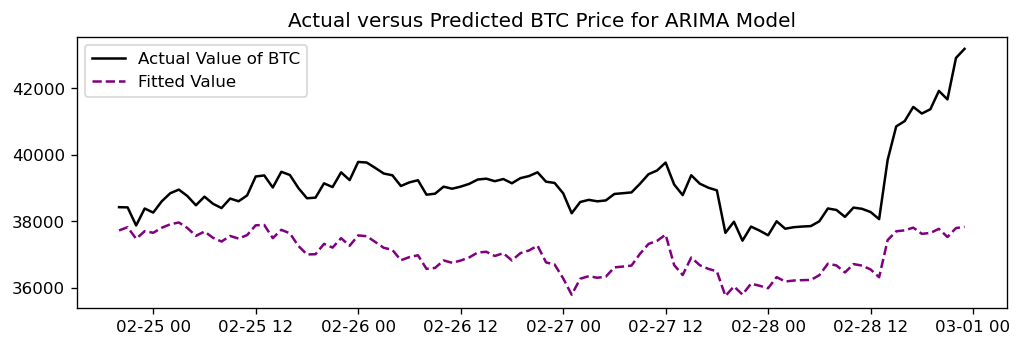

In [102]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X_cut_test, label='Actual Value of BTC', color='black')
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price for ARIMAX Model')
plt.legend()

### Feeding the model known forecasts at time t for predictions at time t+1

In [105]:
def stepwise_forecast_with_known_values_exog(train_vals, test_vals, full_exog, p, d, q, trend):
    forecasts = []
    X = train_vals.copy()
    full_X = X.append(test_vals)
    full_exog = full_exog
    for i in range(0,len(test_vals)):
        model = SARIMAX(endog=full_X[:-len(test_vals)+i], exog= full_exog[:-len(test_vals)+i],
                order=(p, d, q), trend=trend)  
        model = model.fit(disp=False)
        forecast = model.predict(start=len(X_cut_train)+i, end=len(X_cut_train)+i, exog=exog_full[-100+i])
        forecasts.append(forecast[0])
        
    return forecasts       

In [106]:
forecasts = stepwise_forecast_with_known_values_exog(X_cut_train, X_cut_test, exog_full, 2, 1, 1, 'c')

print('The Root Mean Squared Error between the forecasts and the actual values is:', round(rmse(mean_squared_error(forecasts, X_cut_test)),3))

The Root Mean Squared Error between the forecasts and the actual values is: 184.063


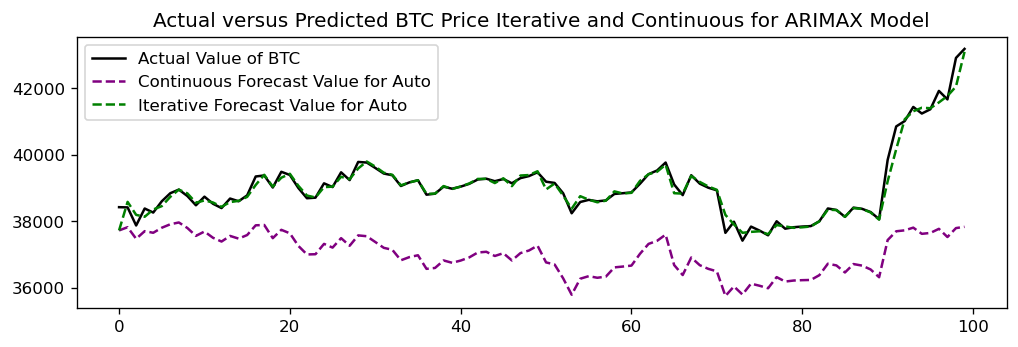

In [107]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot([val for val in X_cut_test], label='Actual Value of BTC', color='black')
plt.plot([val for val in result], label='Continuous Forecast Value for Auto', color='purple', linestyle='--')
plt.plot(forecasts, label='Iterative Forecast Value for Auto', color='green', linestyle='--')
plt.title('Actual versus Predicted BTC Price Iterative and Continuous for ARIMAX Model')
plt.legend()

# Seasonal AutoRegressive Integrated Moving Average

Now, we can integrate *seasonal* information. In doing so, we have to consider *seasonal differencing, autregression, and moving averages*, or $(P,D,Q)_m$. We now call our model $SARIMA(p,d,q),(P,D,Q)_m$ and it has the form:

$$ d_t=\sum_{i=1}^{p}\phi_i d_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \sum_{i=1}^{P}\tilde{\phi_i} d_{t-im} + \sum_{i=1}^{Q} \tilde{\theta_i} \epsilon_{t-im} + c +\epsilon_t $$

Using lag polynomials, this looks like:

$$\phi (L)^p \tilde{\phi} (L^m)^P \Delta^d \Delta^D_m y_t=\theta (L)^q \tilde{\theta} (L^m)^Q \epsilon_t$$

We could also add a *Trend Polynomial*, which could be just the constant, giving us:

$$\phi (L)^p \tilde{\phi} (L^m)^P \Delta^d \Delta^D_m y_t= A(t)+\theta (L)^q \tilde{\theta} (L^m)^Q \epsilon_t$$

Or, another way it is commonly written is:

$$\phi (L)^p \tilde{\phi} (L^m)^P \Delta^d \Delta^D_m y_t= A(t)+\theta (L)^q \tilde{\theta} (L^m)^Q \epsilon_t$$

First, we need to determine if there is any seasonality

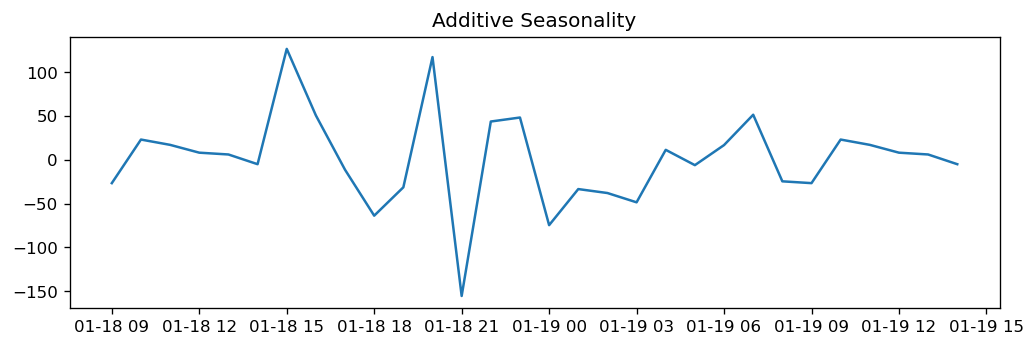

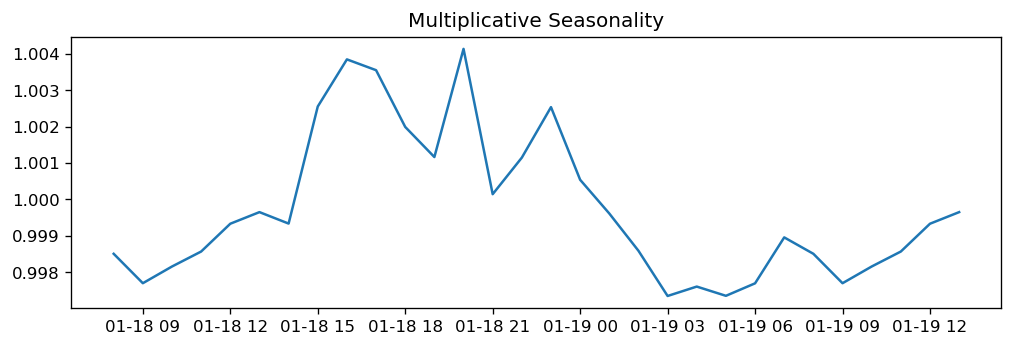

In [108]:
# Plotting seasonality

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
add_season=additive_decomposition.seasonal[0:30]
plt.plot(add_season)
plt.title('Additive Seasonality')
plt.show()

# Plotting seasonality

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
mul_season=multiplicative_decomposition.seasonal[0:30]
plt.plot(mul_season)
plt.title('Multiplicative Seasonality')
plt.show()

We see a very obvious 24-hour season. Given that this is hourly data, this shouldn't be a surprise.

## Auto-ARIMA to find the best parameters

In [109]:
# We will use the auto_arima function to find the best model

model = auto_arima(X_cut_train, information_criterion='aic', seasonal=True, m=24, trend='c', suppress_warnings = True,  step_wise=False, trace=True,
                       stationary=False)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=12858.857, Time=9.94 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=12856.497, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=12855.320, Time=1.10 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=12854.781, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=12856.497, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=12858.504, Time=0.34 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=12855.127, Time=2.50 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=12854.660, Time=4.02 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=12856.656, Time=15.74 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=12852.619, Time=3.00 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=12852.758, Time=0.71 sec
 ARIMA(0,1,0)(1,0,2)[24] intercept   : AIC=12854.617, Time=8.26 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=12853.043, Time=2.95 sec
 ARIMA(1,1,0)(0,0,2)[24] intercept   : AIC=12854.624, Time=4.02 sec
 ARI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  900
Model:             SARIMAX(0, 1, 0)x(0, 0, [1, 2], 24)   Log Likelihood               -6422.310
Date:                                 Tue, 24 May 2022   AIC                          12852.619
Time:                                         21:14:32   BIC                          12871.824
Sample:                                              0   HQIC                         12859.956
                                                 - 900                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.8798     10.867     -0.449      0.653     -26.179      16.420
ma.S.L24       0.0774      0.029      2.688      0.007       0.021       0.134
ma.S.L48      -0.0459      0.033     -1.412      0.158      -0.110       0.018
sigma2      9.471e+04   2778.740     34.083      0.000    8.93e+04       1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               652.09
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fitting the best model found by Auto-ARIMA

In [110]:
start = time.time()
model = SARIMAX(endog=X_cut_train, 
                order=(0, 1, 0), seasonal_order=(0, 0, 2, 24), trend='c')
model = model.fit(disp=False)
end = time.time()
print('This SARIMA training took', end-start)

This SARIMA training took 3.4997828006744385


In [111]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Close   No. Observations:                  900
Model:             SARIMAX(0, 1, 0)x(0, 0, [1, 2], 24)   Log Likelihood               -6422.310
Date:                                 Tue, 24 May 2022   AIC                          12852.619
Time:                                         21:14:36   BIC                          12871.824
Sample:                                     01-18-2022   HQIC                         12859.956
                                          - 02-24-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.8798     10.867     -0.449      0.653     -26.179      16.420
ma.S.L24       0.0774      0.029      2.688      0.007       0.021       0.134
ma.S.L48      -0.0459      0.033     -1.412      0.158      -0.110       0.018
sigma2      9.471e+04   2778.740     34.083      0.000    8.93e+04       1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               652.09
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

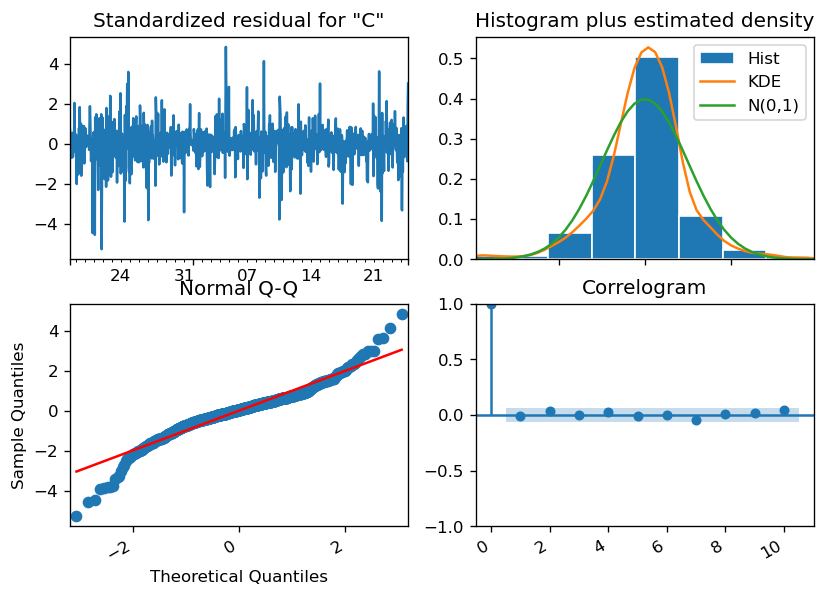

In [112]:
model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

## Out-of-Sample Forecasting

### Using forecasts at time t as input for t+1

In [113]:
result = model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1)

print('The Root Mean Squared Error between the results and the actual values is:', round(rmse(mean_squared_error(result, X_cut_test)),3))

The Root Mean Squared Error between the results and the actual values is: 2245.691


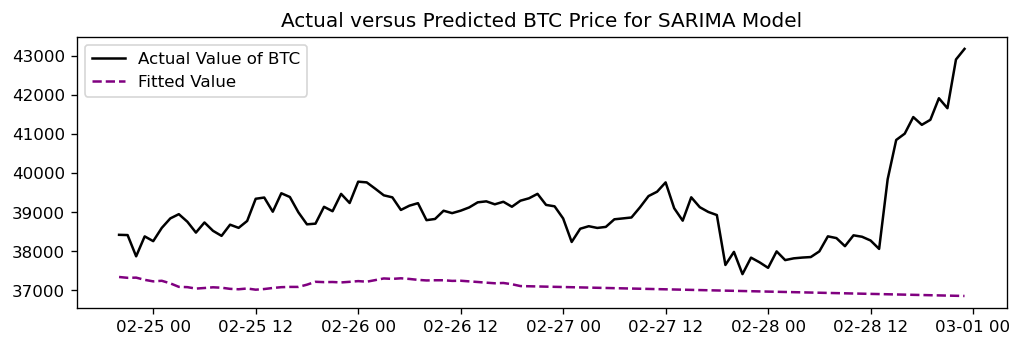

In [114]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X_cut_test, label='Actual Value of BTC', color='black')
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price for SARIMA Model')
plt.legend()

### Feeding the model known forecasts at time t for predictions at time t+1

In [115]:
def stepwise_forecast_with_known_values_seasonal(train_vals, test_vals, p, d, q, P, D, Q, m, trend):
    forecasts = []
    X = train_vals.copy()
    full_X = X.append(test_vals)
    for i in range(0,len(test_vals)):
        model = SARIMAX(endog=full_X[:-len(test_vals)+i], 
                order=(p, d, q), seasonal_order=(P, D, Q, m), trend=trend)  
        model = model.fit(disp=False)
        forecast = model.forecast()
        forecasts.append(forecast[0])
        
    return forecasts        

In [116]:
forecasts = stepwise_forecast_with_known_values_seasonal(X_cut_train, X_cut_test, 0, 1, 0, 0, 0, 2, 24, 'c')

print('The Root Mean Squared Error between the forecasts and the actual values is:', round(rmse(mean_squared_error(forecasts, X_cut_test)),3))

The Root Mean Squared Error between the forecasts and the actual values is: 401.41


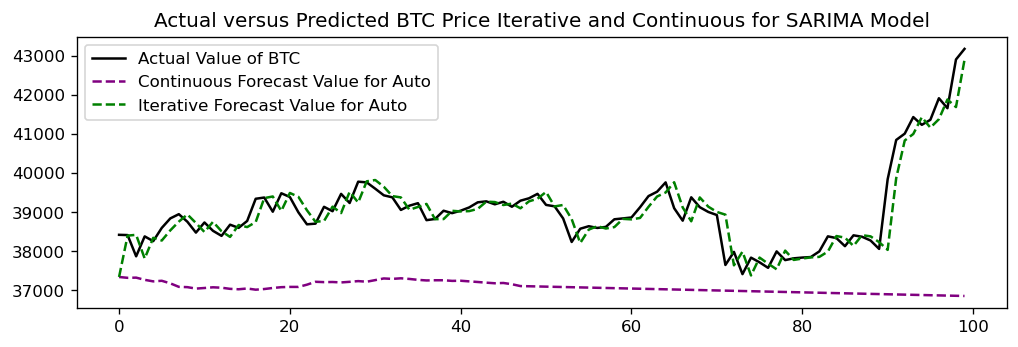

In [118]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot([val for val in X_cut_test], label='Actual Value of BTC', color='black')
plt.plot([val for val in result], label='Continuous Forecast Value for Auto', color='purple', linestyle='--')
plt.plot(forecasts, label='Iterative Forecast Value for Auto', color='green', linestyle='--')
plt.title('Actual versus Predicted BTC Price Iterative and Continuous for SARIMA Model')
plt.legend()

# Seasonal AutoRegressive Integrated Moving Average with eXogenous variables

Finally, we can integrate *seasonal* information. However, we now have to consider *seasonal differencing, autregression, and moving averages*, or $(P,D,Q)_m$. We now call our model $SARIMAX(p,d,q),(P,D,Q)_m$ and it has the form:

$$ d_t=\sum_{i=1}^{p}\phi_i d_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \sum_{i=1}^{r}\beta_i {x_t}^i \sum_{i=1}^{P}\tilde{\phi_i} d_{t-im} + \sum_{i=1}^{Q} \tilde{\theta_i} \epsilon_{t-im} + c +\epsilon_t $$

Using lag polynomials, this looks like:

$$\phi (L)^p \tilde{\phi} (L^m)^P \Delta^d \Delta^D_m y_t=\theta (L)^q \tilde{\theta} (L^m)^Q \epsilon_t + \sum_{i=1}^{r}\beta_i {x_t}^i$$

We could also add a *Trend Polynomial*, which could be just the constant, giving us:

$$\phi (L)^p \tilde{\phi} (L^m)^P \Delta^d \Delta^D_m y_t= A(t)+\theta (L)^q \tilde{\theta} (L^m)^Q \epsilon_t + \sum_{i=1}^{r}\beta_i {x_t}^i$$

Or, another way it is commonly written is:

$$y_t = \sum_{i=1}^{r}\beta_i {x_t}^i +u_t$$

$$\phi (L)^p \tilde{\phi} (L^m)^P \Delta^d \Delta^D_m u_t= A(t)+\theta (L)^q \tilde{\theta} (L^m)^Q \epsilon_t$$

## Auto-ARIMA to find the best parameters

In [119]:
auto_model = auto_arima(X_cut_train, exog_train, information_criterion='aic', seasonal=True, m=24,
                        trend='c', suppress_warnings = True,  step_wise=False, trace=True,
                        stationary=False)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=11349.919, Time=6.75 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=11418.771, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=11405.298, Time=1.20 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=11410.368, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=11418.771, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=11347.960, Time=4.73 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=11346.019, Time=1.86 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=11347.962, Time=4.80 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=11344.670, Time=0.90 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=11346.592, Time=3.28 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=11346.590, Time=2.94 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=11348.508, Time=4.73 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=11374.406, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=11352.153, Time=0.55 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  900
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -5666.034
Date:                Tue, 24 May 2022   AIC                          11344.068
Time:                        21:21:02   BIC                          11372.876
Sample:                             0   HQIC                         11355.074
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7477      2.159     -0.809      0.418      -5.980       2.484
x1            41.6271      0.436     95.389      0.000      40.772      42.482
ar.L1          0.6060      0.074      8.228      0.000       0.462       0.750
ar.L2          0.1523      0.023      6.697      0.000       0.108       0.197
ma.L1         -0.5401      0.075     -7.159      0.000      -0.688      -0.392
sigma2      1.743e+04    409.906     42.531      0.000    1.66e+04    1.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              6839.15
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We note that this is the *same* model found in the ARIMAX section, leading us to conclude that Auto-ARIMA doesn't find and value in adding seasonality to the model.

## Fitting the best model found by Auto-ARIMA

In [123]:
start = time.time()
model = SARIMAX(endog=X_cut_train, exog=exog_train, order=(2, 1, 1), seasonal_order=(0, 0, 0, 24), trend='c')
model = model.fit(disp=False)
end = time.time()
print('This SARIMAX training took', end-start)

This SARIMAX training took 1.078369140625


In [124]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -5666.034
Date:                Tue, 24 May 2022   AIC                          11344.068
Time:                        21:21:33   BIC                          11372.876
Sample:                    01-18-2022   HQIC                         11355.074
                         - 02-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7477      2.159     -0.809      0.418      -5.980       2.484
x1            41.6271      0.436     95.389      0.000      40.772      42.482
ar.L1          0.6060      0.074      8.228      0.000       0.462       0.750
ar.L2          0.1523      0.023      6.697      0.000       0.108       0.197
ma.L1         -0.5401      0.075     -7.159      0.000      -0.688      -0.392
sigma2      1.743e+04    409.906     42.531      0.000    1.66e+04    1.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              6839.15
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

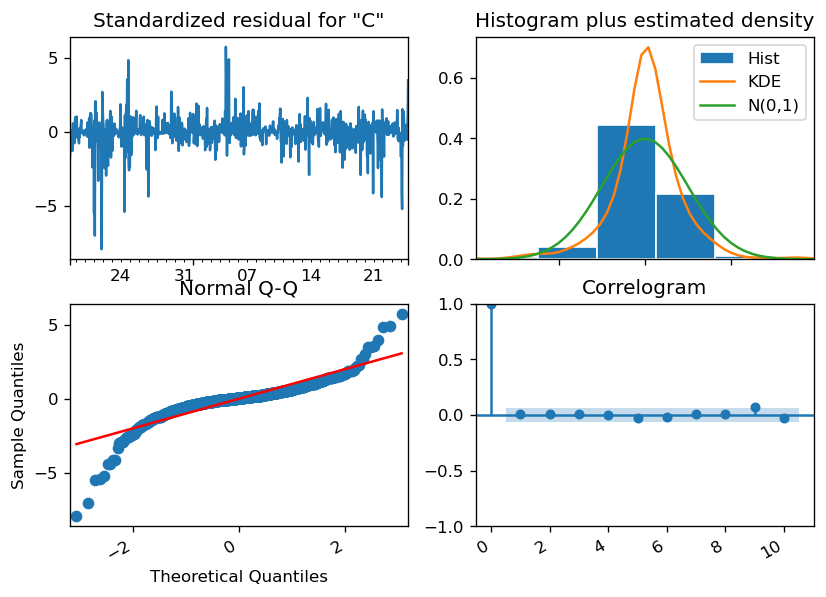

In [125]:
model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

## Out-of-Sample Forecasting

### Using forecasts at time t as input for t+1

In [126]:
result = model.predict(start=len(X_cut_train), end=len(X_cut_train)+len(X_cut_test)-1, exog=exog_test)

print('The Root Mean Squared Error between the results and the actual values is:', round(rmse(mean_squared_error(result, X_cut_test)),3))

The Root Mean Squared Error between the results and the actual values is: 2197.814


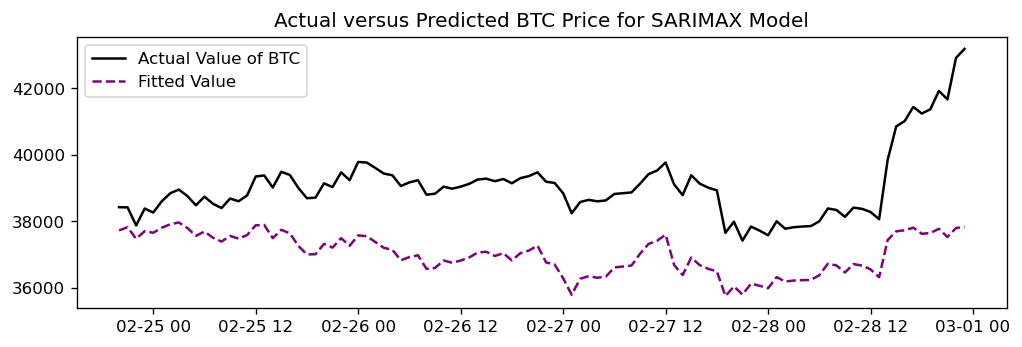

In [127]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X_cut_test, label='Actual Value of BTC', color='black')
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price for SARIMAX Model')
plt.legend()

### Feeding the model known forecasts at time t for predictions at time t+1

In [130]:
def stepwise_forecast_with_known_values_seasonal_exog(train_vals, test_vals, full_exog, p, d, q, P, D, Q, m, trend):
    forecasts = []
    X = train_vals.copy()
    full_X = X.append(test_vals)
    full_exog = full_exog
    for i in range(0,len(test_vals)):
        model = SARIMAX(endog=full_X[:-len(test_vals)+i], exog= full_exog[:-len(test_vals)+i],
                order=(p, d, q), seasonal_order=(P, D, Q, m), trend=trend)  
        model = model.fit(disp=False)
        forecast = model.predict(start=len(X_cut_train)+i, end=len(X_cut_train)+i, exog=full_exog[-100+i])
        forecasts.append(forecast[0])
        
    return forecasts        

In [131]:
forecasts = stepwise_forecast_with_known_values_seasonal_exog(X_cut_train, X_cut_test, exog_full, 2, 1, 1, 0, 0, 0, 24, 'c')

print('The Root Mean Squared Error between the forecasts and the actual values is:', round(rmse(mean_squared_error(forecasts, X_cut_test)),3))

The Root Mean Squared Error between the forecasts and the actual values is: 184.063


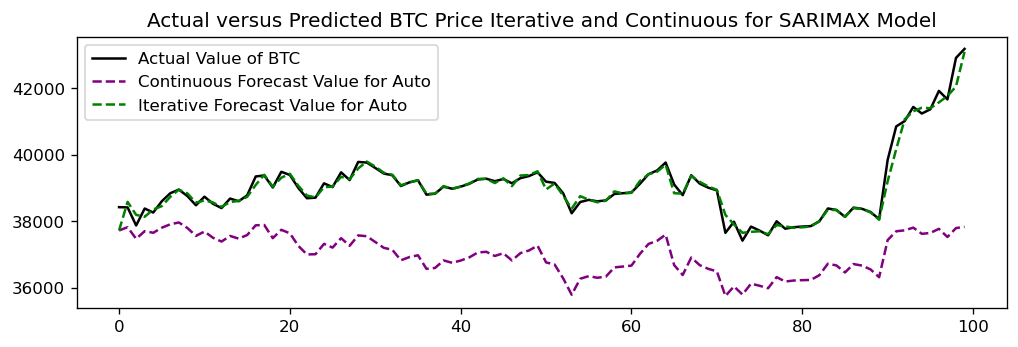

In [132]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot([val for val in X_cut_test], label='Actual Value of BTC', color='black')
plt.plot([val for val in result], label='Continuous Forecast Value for Auto', color='purple', linestyle='--')
plt.plot(forecasts, label='Iterative Forecast Value for Auto', color='green', linestyle='--')
plt.title('Actual versus Predicted BTC Price Iterative and Continuous for SARIMAX Model')
plt.legend()

# Martingale Model

Just as a comparison, let us consider a *Martingale Model*. Recall the definition of a martingale:

$$ \{X_t \} $$ is martingale if $$ \mathbb{E}[X_{t+1}|X_0, ..., X_t]=X_t $$

So, we will simply build our model where the value at $t+1$ is equal to the value at $t$. We will then feed the model each value at that time.

In [147]:
mart_model = X_cut_test[1:]

print('The Root Mean Squared Error between the forecasts and the actual values is:', round(rmse(mean_squared_error(mart_model, X_cut_test[:-1])),3))

The Root Mean Squared Error between the forecasts and the actual values is: 383.347


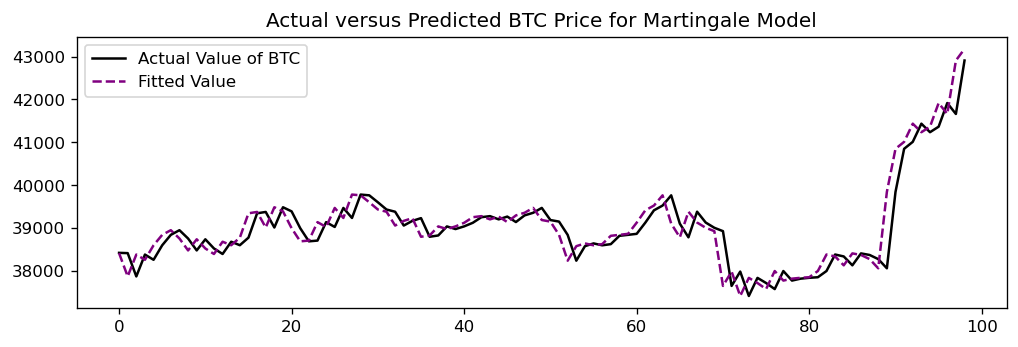

In [153]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(list(X_cut_test[:-1]), label='Actual Value of BTC', color='black')
plt.plot(list(mart_model), label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price for Martingale Model')
plt.legend()

# Saving and Reloading Models

In [14]:
# # Save the model

# model.save('Models/NAME.pkl')

In [17]:
# # Reload the model

# model=SARIMAXResults.load('Models/NAME.pkl')